## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

mkdir: cannot create directory ‘./ckpts’: File exists


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 8
CROP_SIZE = 768
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

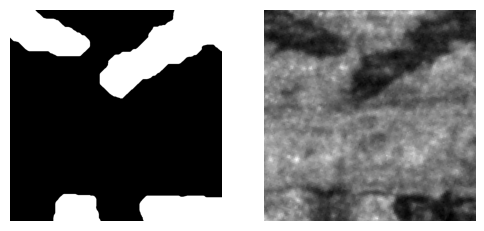

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4083

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface>0.001) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-384 if x1 != 0 else 0, 384)
        y_offset = random.randint(-384 if y1 != 0 else 0, 384)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [18]:
i = random.randint(0, len(dataset_train))
img, mask = dataset_train[i]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

In [26]:
n_iter = 1000
ratios=[]
for i in tqdm(range(n_iter)):
    idx = random.randint(0, len(dataset_train)-1)
    img, mask = dataset_train[idx]
    ratio = mask.sum() / (mask.shape[1] * mask.shape[2])
    ratios.append(ratio)

100%|██████████| 1000/1000 [01:36<00:00, 10.35it/s]


(array([167.,  67.,  66.,  78.,  79.,  70.,  90.,  68.,  61.,  49.,  44.,
         47.,  27.,  31.,  25.,  15.,   9.,   2.,   1.,   4.]),
 array([0.        , 0.02616594, 0.05233188, 0.07849783, 0.10466377,
        0.13082971, 0.15699565, 0.18316159, 0.20932753, 0.23549347,
        0.26165941, 0.28782535, 0.31399131, 0.34015724, 0.36632317,
        0.39248914, 0.41865507, 0.444821  , 0.47098693, 0.49715289,
        0.52331883]),
 <BarContainer object of 20 artists>)

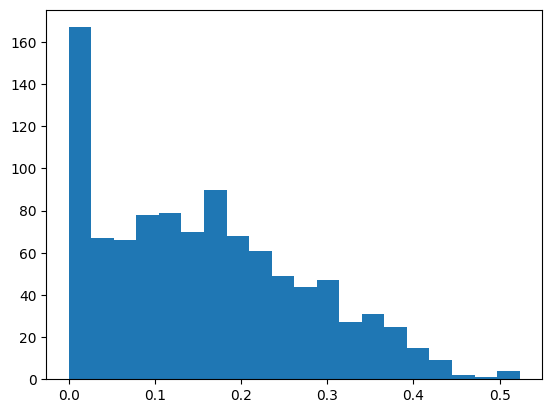

In [27]:
plt.hist(ratios, bins=20)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [13]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=20, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    # if epoch >= 10:
    #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 20GB  LR : 4.00E-06  Loss: 0.7951: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it]                                                                                                                                                                 
Val Loss: 0.7034: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137168
Threshold : 0.30	FBeta : 0.143233
Threshold : 0.35	FBeta : 0.200955
Threshold : 0.40	FBeta : 0.214909
Threshold : 0.45	FBeta : 0.224236
Threshold : 0.50	FBeta : 0.229067
Threshold : 0.55	FBeta : 0.216252
Threshold : 0.60	FBeta : 0.179206
Threshold : 0.65	FBeta : 0.092475
Threshold : 0.70	FBeta : 0.009449
Threshold : 0.75	FBeta : 0.000510
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 22.2GB  LR : 6.89E-06  Loss: 0.7747: 100%|██████████| 29/29 [05:16<00:00, 10.92s/it]                                                                                                                                                               
Val Loss: 0.7233: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.137140
Threshold : 0.25	FBeta : 0.137298
Threshold : 0.30	FBeta : 0.138087
Threshold : 0.35	FBeta : 0.153560
Threshold : 0.40	FBeta : 0.213278
Threshold : 0.45	FBeta : 0.232427
Threshold : 0.50	FBeta : 0.245758
Threshold : 0.55	FBeta : 0.260760
Threshold : 0.60	FBeta : 0.277770
Threshold : 0.65	FBeta : 0.277870
Threshold : 0.70	FBeta : 0.234664
Threshold : 0.75	FBeta : 0.128653
Threshold : 0.80	FBeta : 0.033359



Epoch 3/50  Mem : 22.2GB  LR : 1.52E-05  Loss: 0.7571: 100%|██████████| 29/29 [05:23<00:00, 11.17s/it]                                                                                                                                                               
Val Loss: 0.6887: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.138099
Threshold : 0.25	FBeta : 0.182606
Threshold : 0.30	FBeta : 0.196555
Threshold : 0.35	FBeta : 0.205991
Threshold : 0.40	FBeta : 0.218110
Threshold : 0.45	FBeta : 0.230813
Threshold : 0.50	FBeta : 0.246299
Threshold : 0.55	FBeta : 0.275126
Threshold : 0.60	FBeta : 0.308421
Threshold : 0.65	FBeta : 0.325218
Threshold : 0.70	FBeta : 0.312795
Threshold : 0.75	FBeta : 0.258811
Threshold : 0.80	FBeta : 0.164688



Epoch 4/50  Mem : 22.2GB  LR : 2.80E-05  Loss: 0.7266: 100%|██████████| 29/29 [03:55<00:00,  8.12s/it]                                                                                                                                                               
Val Loss: 0.6890: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.137375
Threshold : 0.25	FBeta : 0.187968
Threshold : 0.30	FBeta : 0.203790
Threshold : 0.35	FBeta : 0.211168
Threshold : 0.40	FBeta : 0.222588
Threshold : 0.45	FBeta : 0.233064
Threshold : 0.50	FBeta : 0.247635
Threshold : 0.55	FBeta : 0.276296
Threshold : 0.60	FBeta : 0.308012
Threshold : 0.65	FBeta : 0.333408
Threshold : 0.70	FBeta : 0.344934
Threshold : 0.75	FBeta : 0.339890
Threshold : 0.80	FBeta : 0.307304



Epoch 5/50  Mem : 22.2GB  LR : 4.37E-05  Loss: 0.6867: 100%|██████████| 29/29 [03:17<00:00,  6.81s/it]                                                                                                                                                               
Val Loss: 0.8165: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.137135
Threshold : 0.25	FBeta : 0.137252
Threshold : 0.30	FBeta : 0.164311
Threshold : 0.35	FBeta : 0.205460
Threshold : 0.40	FBeta : 0.215836
Threshold : 0.45	FBeta : 0.222497
Threshold : 0.50	FBeta : 0.236390
Threshold : 0.55	FBeta : 0.244152
Threshold : 0.60	FBeta : 0.252916
Threshold : 0.65	FBeta : 0.264400
Threshold : 0.70	FBeta : 0.279943
Threshold : 0.75	FBeta : 0.297851
Threshold : 0.80	FBeta : 0.321959




Epoch 6/50  Mem : 22.2GB  LR : 6.03E-05  Loss: 0.6535: 100%|██████████| 29/29 [02:52<00:00,  5.93s/it]                                                                                                                                                               
Val Loss: 0.6567: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.218664
Threshold : 0.25	FBeta : 0.230440
Threshold : 0.30	FBeta : 0.238888
Threshold : 0.35	FBeta : 0.246523
Threshold : 0.40	FBeta : 0.259809
Threshold : 0.45	FBeta : 0.274443
Threshold : 0.50	FBeta : 0.291308
Threshold : 0.55	FBeta : 0.310664
Threshold : 0.60	FBeta : 0.331173
Threshold : 0.65	FBeta : 0.351831
Threshold : 0.70	FBeta : 0.372810
Threshold : 0.75	FBeta : 0.389324
Threshold : 0.80	FBeta : 0.401928



Epoch 7/50  Mem : 22.2GB  LR : 7.60E-05  Loss: 0.6395: 100%|██████████| 29/29 [02:21<00:00,  4.88s/it]                                                                                                                                                               
Val Loss: 0.6376: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.129215
Threshold : 0.25	FBeta : 0.197528
Threshold : 0.30	FBeta : 0.204711
Threshold : 0.35	FBeta : 0.188991
Threshold : 0.40	FBeta : 0.168807
Threshold : 0.45	FBeta : 0.145646
Threshold : 0.50	FBeta : 0.127281
Threshold : 0.55	FBeta : 0.114671
Threshold : 0.60	FBeta : 0.101384
Threshold : 0.65	FBeta : 0.084604
Threshold : 0.70	FBeta : 0.066523
Threshold : 0.75	FBeta : 0.045501
Threshold : 0.80	FBeta : 0.026609




Epoch 8/50  Mem : 22.2GB  LR : 8.88E-05  Loss: 0.6022: 100%|██████████| 29/29 [02:21<00:00,  4.89s/it]                                                                                                                                                               
Val Loss: 1.0277: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.137566
Threshold : 0.25	FBeta : 0.214822
Threshold : 0.30	FBeta : 0.226581
Threshold : 0.35	FBeta : 0.234505
Threshold : 0.40	FBeta : 0.238844
Threshold : 0.45	FBeta : 0.243569
Threshold : 0.50	FBeta : 0.247567
Threshold : 0.55	FBeta : 0.252558
Threshold : 0.60	FBeta : 0.260012
Threshold : 0.65	FBeta : 0.265847
Threshold : 0.70	FBeta : 0.269790
Threshold : 0.75	FBeta : 0.275477
Threshold : 0.80	FBeta : 0.279091




Epoch 9/50  Mem : 22.2GB  LR : 9.71E-05  Loss: 0.5810: 100%|██████████| 29/29 [02:15<00:00,  4.66s/it]                                                                                                                                                               
Val Loss: 0.5627: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.248608
Threshold : 0.25	FBeta : 0.294667
Threshold : 0.30	FBeta : 0.356012
Threshold : 0.35	FBeta : 0.366245
Threshold : 0.40	FBeta : 0.306902
Threshold : 0.45	FBeta : 0.243354
Threshold : 0.50	FBeta : 0.180880
Threshold : 0.55	FBeta : 0.095059
Threshold : 0.60	FBeta : 0.058597
Threshold : 0.65	FBeta : 0.039044
Threshold : 0.70	FBeta : 0.026331
Threshold : 0.75	FBeta : 0.016895
Threshold : 0.80	FBeta : 0.008180




Epoch 10/50  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.5629: 100%|██████████| 29/29 [01:36<00:00,  3.33s/it]                                                                                                                                                              
Val Loss: 0.5597: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.224990
Threshold : 0.25	FBeta : 0.269038
Threshold : 0.30	FBeta : 0.315156
Threshold : 0.35	FBeta : 0.354108
Threshold : 0.40	FBeta : 0.380546
Threshold : 0.45	FBeta : 0.398651
Threshold : 0.50	FBeta : 0.417668
Threshold : 0.55	FBeta : 0.453686
Threshold : 0.60	FBeta : 0.463242
Threshold : 0.65	FBeta : 0.464468
Threshold : 0.70	FBeta : 0.469309
Threshold : 0.75	FBeta : 0.465225
Threshold : 0.80	FBeta : 0.438295



Epoch 11/50  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.5576: 100%|██████████| 29/29 [01:44<00:00,  3.60s/it]                                                                                                                                                              
Val Loss: 0.5539: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.286989
Threshold : 0.25	FBeta : 0.366213
Threshold : 0.30	FBeta : 0.384292
Threshold : 0.35	FBeta : 0.385744
Threshold : 0.40	FBeta : 0.382184
Threshold : 0.45	FBeta : 0.379246
Threshold : 0.50	FBeta : 0.376772
Threshold : 0.55	FBeta : 0.372338
Threshold : 0.60	FBeta : 0.359369
Threshold : 0.65	FBeta : 0.339241
Threshold : 0.70	FBeta : 0.315230
Threshold : 0.75	FBeta : 0.296729
Threshold : 0.80	FBeta : 0.279655




Epoch 12/50  Mem : 22.2GB  LR : 9.99E-05  Loss: 0.5465: 100%|██████████| 29/29 [01:18<00:00,  2.70s/it]                                                                                                                                                              
Val Loss: 0.8597: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.230416
Threshold : 0.25	FBeta : 0.235644
Threshold : 0.30	FBeta : 0.242130
Threshold : 0.35	FBeta : 0.247779
Threshold : 0.40	FBeta : 0.253201
Threshold : 0.45	FBeta : 0.258784
Threshold : 0.50	FBeta : 0.263654
Threshold : 0.55	FBeta : 0.274423
Threshold : 0.60	FBeta : 0.284103
Threshold : 0.65	FBeta : 0.293016
Threshold : 0.70	FBeta : 0.302668
Threshold : 0.75	FBeta : 0.314661
Threshold : 0.80	FBeta : 0.328810




Epoch 13/50  Mem : 22.2GB  LR : 9.97E-05  Loss: 0.5404: 100%|██████████| 29/29 [02:24<00:00,  4.98s/it]                                                                                                                                                              
Val Loss: 0.5682: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.235303
Threshold : 0.25	FBeta : 0.266199
Threshold : 0.30	FBeta : 0.304703
Threshold : 0.35	FBeta : 0.330987
Threshold : 0.40	FBeta : 0.347026
Threshold : 0.45	FBeta : 0.360031
Threshold : 0.50	FBeta : 0.376329
Threshold : 0.55	FBeta : 0.411163
Threshold : 0.60	FBeta : 0.428842
Threshold : 0.65	FBeta : 0.443937
Threshold : 0.70	FBeta : 0.455842
Threshold : 0.75	FBeta : 0.463528
Threshold : 0.80	FBeta : 0.465990




Epoch 14/50  Mem : 22.2GB  LR : 9.95E-05  Loss: 0.5262: 100%|██████████| 29/29 [03:07<00:00,  6.47s/it]                                                                                                                                                              
Val Loss: 0.5650: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.260059
Threshold : 0.25	FBeta : 0.294868
Threshold : 0.30	FBeta : 0.311037
Threshold : 0.35	FBeta : 0.321089
Threshold : 0.40	FBeta : 0.329118
Threshold : 0.45	FBeta : 0.335986
Threshold : 0.50	FBeta : 0.346207
Threshold : 0.55	FBeta : 0.364150
Threshold : 0.60	FBeta : 0.374708
Threshold : 0.65	FBeta : 0.382087
Threshold : 0.70	FBeta : 0.388154
Threshold : 0.75	FBeta : 0.392087
Threshold : 0.80	FBeta : 0.400749




Epoch 15/50  Mem : 22.2GB  LR : 9.92E-05  Loss: 0.5173: 100%|██████████| 29/29 [02:36<00:00,  5.41s/it]                                                                                                                                                              
Val Loss: 0.5514: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.298295
Threshold : 0.25	FBeta : 0.329037
Threshold : 0.30	FBeta : 0.339001
Threshold : 0.35	FBeta : 0.344479
Threshold : 0.40	FBeta : 0.352998
Threshold : 0.45	FBeta : 0.360265
Threshold : 0.50	FBeta : 0.375632
Threshold : 0.55	FBeta : 0.375930
Threshold : 0.60	FBeta : 0.378055
Threshold : 0.65	FBeta : 0.368879
Threshold : 0.70	FBeta : 0.349429
Threshold : 0.75	FBeta : 0.324960
Threshold : 0.80	FBeta : 0.294409




Epoch 16/50  Mem : 22.2GB  LR : 9.89E-05  Loss: 0.5086: 100%|██████████| 29/29 [01:37<00:00,  3.35s/it]                                                                                                                                                              
Val Loss: 0.5566: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.284117
Threshold : 0.25	FBeta : 0.326468
Threshold : 0.30	FBeta : 0.344850
Threshold : 0.35	FBeta : 0.356935
Threshold : 0.40	FBeta : 0.364731
Threshold : 0.45	FBeta : 0.374050
Threshold : 0.50	FBeta : 0.386213
Threshold : 0.55	FBeta : 0.406753
Threshold : 0.60	FBeta : 0.406546
Threshold : 0.65	FBeta : 0.404960
Threshold : 0.70	FBeta : 0.397530
Threshold : 0.75	FBeta : 0.387660
Threshold : 0.80	FBeta : 0.370897




Epoch 17/50  Mem : 22.2GB  LR : 9.85E-05  Loss: 0.5004: 100%|██████████| 29/29 [01:42<00:00,  3.54s/it]                                                                                                                                                              
Val Loss: 0.5058: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.341908
Threshold : 0.25	FBeta : 0.375448
Threshold : 0.30	FBeta : 0.393960
Threshold : 0.35	FBeta : 0.404860
Threshold : 0.40	FBeta : 0.414385
Threshold : 0.45	FBeta : 0.423086
Threshold : 0.50	FBeta : 0.435011
Threshold : 0.55	FBeta : 0.452638
Threshold : 0.60	FBeta : 0.464042
Threshold : 0.65	FBeta : 0.473946
Threshold : 0.70	FBeta : 0.484847
Threshold : 0.75	FBeta : 0.493133
Threshold : 0.80	FBeta : 0.498429



Epoch 18/50  Mem : 22.2GB  LR : 9.81E-05  Loss: 0.5089: 100%|██████████| 29/29 [01:00<00:00,  2.07s/it]                                                                                                                                                              
Val Loss: 0.5395: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.299855
Threshold : 0.25	FBeta : 0.324311
Threshold : 0.30	FBeta : 0.336416
Threshold : 0.35	FBeta : 0.344220
Threshold : 0.40	FBeta : 0.351454
Threshold : 0.45	FBeta : 0.361110
Threshold : 0.50	FBeta : 0.377904
Threshold : 0.55	FBeta : 0.412685
Threshold : 0.60	FBeta : 0.426745
Threshold : 0.65	FBeta : 0.439770
Threshold : 0.70	FBeta : 0.452132
Threshold : 0.75	FBeta : 0.463271
Threshold : 0.80	FBeta : 0.471911




Epoch 19/50  Mem : 22.2GB  LR : 9.76E-05  Loss: 0.4917: 100%|██████████| 29/29 [01:31<00:00,  3.16s/it]                                                                                                                                                              
Val Loss: 0.5406: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.291821
Threshold : 0.25	FBeta : 0.316884
Threshold : 0.30	FBeta : 0.330990
Threshold : 0.35	FBeta : 0.340116
Threshold : 0.40	FBeta : 0.346316
Threshold : 0.45	FBeta : 0.354151
Threshold : 0.50	FBeta : 0.363455
Threshold : 0.55	FBeta : 0.376158
Threshold : 0.60	FBeta : 0.382827
Threshold : 0.65	FBeta : 0.385898
Threshold : 0.70	FBeta : 0.380801
Threshold : 0.75	FBeta : 0.366434
Threshold : 0.80	FBeta : 0.339359




Epoch 20/50  Mem : 22.2GB  LR : 9.70E-05  Loss: 0.4819: 100%|██████████| 29/29 [01:17<00:00,  2.67s/it]                                                                                                                                                              
Val Loss: 1.0009: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.245703
Threshold : 0.25	FBeta : 0.253970
Threshold : 0.30	FBeta : 0.259641
Threshold : 0.35	FBeta : 0.263754
Threshold : 0.40	FBeta : 0.266680
Threshold : 0.45	FBeta : 0.269208
Threshold : 0.50	FBeta : 0.272157
Threshold : 0.55	FBeta : 0.278744
Threshold : 0.60	FBeta : 0.286010
Threshold : 0.65	FBeta : 0.293305
Threshold : 0.70	FBeta : 0.300983
Threshold : 0.75	FBeta : 0.309476
Threshold : 0.80	FBeta : 0.319834




Epoch 21/50  Mem : 22.2GB  LR : 9.64E-05  Loss: 0.4767: 100%|██████████| 29/29 [01:39<00:00,  3.41s/it]                                                                                                                                                              
Val Loss: 0.4955: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.360345
Threshold : 0.25	FBeta : 0.387197
Threshold : 0.30	FBeta : 0.402523
Threshold : 0.35	FBeta : 0.412431
Threshold : 0.40	FBeta : 0.420700
Threshold : 0.45	FBeta : 0.429969
Threshold : 0.50	FBeta : 0.441465
Threshold : 0.55	FBeta : 0.457819
Threshold : 0.60	FBeta : 0.467847
Threshold : 0.65	FBeta : 0.474449
Threshold : 0.70	FBeta : 0.479853
Threshold : 0.75	FBeta : 0.483514
Threshold : 0.80	FBeta : 0.486569




Epoch 22/50  Mem : 22.2GB  LR : 9.57E-05  Loss: 0.4644: 100%|██████████| 29/29 [01:03<00:00,  2.19s/it]                                                                                                                                                              
Val Loss: 0.5494: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.305635
Threshold : 0.25	FBeta : 0.346382
Threshold : 0.30	FBeta : 0.357481
Threshold : 0.35	FBeta : 0.362313
Threshold : 0.40	FBeta : 0.366139
Threshold : 0.45	FBeta : 0.370550
Threshold : 0.50	FBeta : 0.376174
Threshold : 0.55	FBeta : 0.384039
Threshold : 0.60	FBeta : 0.385381
Threshold : 0.65	FBeta : 0.385897
Threshold : 0.70	FBeta : 0.386629
Threshold : 0.75	FBeta : 0.384805
Threshold : 0.80	FBeta : 0.381770




Epoch 23/50  Mem : 22.2GB  LR : 9.49E-05  Loss: 0.4595: 100%|██████████| 29/29 [01:21<00:00,  2.80s/it]                                                                                                                                                              
Val Loss: 0.5502: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.292203
Threshold : 0.25	FBeta : 0.310431
Threshold : 0.30	FBeta : 0.322750
Threshold : 0.35	FBeta : 0.331438
Threshold : 0.40	FBeta : 0.339743
Threshold : 0.45	FBeta : 0.345811
Threshold : 0.50	FBeta : 0.352827
Threshold : 0.55	FBeta : 0.364480
Threshold : 0.60	FBeta : 0.368253
Threshold : 0.65	FBeta : 0.371924
Threshold : 0.70	FBeta : 0.373448
Threshold : 0.75	FBeta : 0.372498
Threshold : 0.80	FBeta : 0.368355




Epoch 24/50  Mem : 22.2GB  LR : 9.41E-05  Loss: 0.4530: 100%|██████████| 29/29 [01:12<00:00,  2.50s/it]                                                                                                                                                              
Val Loss: 0.4988: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.425801
Threshold : 0.25	FBeta : 0.458695
Threshold : 0.30	FBeta : 0.468984
Threshold : 0.35	FBeta : 0.473109
Threshold : 0.40	FBeta : 0.475116
Threshold : 0.45	FBeta : 0.476409
Threshold : 0.50	FBeta : 0.474647
Threshold : 0.55	FBeta : 0.460729
Threshold : 0.60	FBeta : 0.446048
Threshold : 0.65	FBeta : 0.430884
Threshold : 0.70	FBeta : 0.412416
Threshold : 0.75	FBeta : 0.390623
Threshold : 0.80	FBeta : 0.362846




Epoch 25/50  Mem : 22.2GB  LR : 9.33E-05  Loss: 0.4627: 100%|██████████| 29/29 [00:44<00:00,  1.54s/it]                                                                                                                                                              
Val Loss: 0.4811: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.417875
Threshold : 0.25	FBeta : 0.445740
Threshold : 0.30	FBeta : 0.466841
Threshold : 0.35	FBeta : 0.480150
Threshold : 0.40	FBeta : 0.497081
Threshold : 0.45	FBeta : 0.505267
Threshold : 0.50	FBeta : 0.513430
Threshold : 0.55	FBeta : 0.529329
Threshold : 0.60	FBeta : 0.532516
Threshold : 0.65	FBeta : 0.530667
Threshold : 0.70	FBeta : 0.521754
Threshold : 0.75	FBeta : 0.505989
Threshold : 0.80	FBeta : 0.477773



Epoch 26/50  Mem : 22.2GB  LR : 9.24E-05  Loss: 0.4520: 100%|██████████| 29/29 [00:53<00:00,  1.84s/it]                                                                                                                                                              
Val Loss: 0.7056: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.291515
Threshold : 0.25	FBeta : 0.304519
Threshold : 0.30	FBeta : 0.313139
Threshold : 0.35	FBeta : 0.319646
Threshold : 0.40	FBeta : 0.325434
Threshold : 0.45	FBeta : 0.331730
Threshold : 0.50	FBeta : 0.340545
Threshold : 0.55	FBeta : 0.358438
Threshold : 0.60	FBeta : 0.367876
Threshold : 0.65	FBeta : 0.375849
Threshold : 0.70	FBeta : 0.383755
Threshold : 0.75	FBeta : 0.392168
Threshold : 0.80	FBeta : 0.401222




Epoch 27/50  Mem : 22.2GB  LR : 9.15E-05  Loss: 0.4607: 100%|██████████| 29/29 [01:01<00:00,  2.13s/it]                                                                                                                                                              
Val Loss: 0.5185: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.320031
Threshold : 0.25	FBeta : 0.333029
Threshold : 0.30	FBeta : 0.342773
Threshold : 0.35	FBeta : 0.351401
Threshold : 0.40	FBeta : 0.360271
Threshold : 0.45	FBeta : 0.370779
Threshold : 0.50	FBeta : 0.388556
Threshold : 0.55	FBeta : 0.413627
Threshold : 0.60	FBeta : 0.426875
Threshold : 0.65	FBeta : 0.438751
Threshold : 0.70	FBeta : 0.450343
Threshold : 0.75	FBeta : 0.464939
Threshold : 0.80	FBeta : 0.479545




Epoch 28/50  Mem : 22.2GB  LR : 9.05E-05  Loss: 0.4468: 100%|██████████| 29/29 [01:12<00:00,  2.49s/it]                                                                                                                                                              
Val Loss: 0.5678: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.324347
Threshold : 0.25	FBeta : 0.335739
Threshold : 0.30	FBeta : 0.345022
Threshold : 0.35	FBeta : 0.352759
Threshold : 0.40	FBeta : 0.360096
Threshold : 0.45	FBeta : 0.367514
Threshold : 0.50	FBeta : 0.375984
Threshold : 0.55	FBeta : 0.387221
Threshold : 0.60	FBeta : 0.393384
Threshold : 0.65	FBeta : 0.399272
Threshold : 0.70	FBeta : 0.404379
Threshold : 0.75	FBeta : 0.409800
Threshold : 0.80	FBeta : 0.416133




Epoch 29/50  Mem : 22.2GB  LR : 8.94E-05  Loss: 0.4430: 100%|██████████| 29/29 [00:48<00:00,  1.66s/it]                                                                                                                                                              
Val Loss: 0.5619: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.321906
Threshold : 0.25	FBeta : 0.331124
Threshold : 0.30	FBeta : 0.338424
Threshold : 0.35	FBeta : 0.344731
Threshold : 0.40	FBeta : 0.350964
Threshold : 0.45	FBeta : 0.357913
Threshold : 0.50	FBeta : 0.366333
Threshold : 0.55	FBeta : 0.379725
Threshold : 0.60	FBeta : 0.388545
Threshold : 0.65	FBeta : 0.397047
Threshold : 0.70	FBeta : 0.404415
Threshold : 0.75	FBeta : 0.413118
Threshold : 0.80	FBeta : 0.423597




Epoch 30/50  Mem : 22.2GB  LR : 8.83E-05  Loss: 0.4245: 100%|██████████| 29/29 [01:01<00:00,  2.11s/it]                                                                                                                                                              
Val Loss: 0.5480: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.320813
Threshold : 0.25	FBeta : 0.332220
Threshold : 0.30	FBeta : 0.339774
Threshold : 0.35	FBeta : 0.346280
Threshold : 0.40	FBeta : 0.352494
Threshold : 0.45	FBeta : 0.358561
Threshold : 0.50	FBeta : 0.367846
Threshold : 0.55	FBeta : 0.383804
Threshold : 0.60	FBeta : 0.393323
Threshold : 0.65	FBeta : 0.402842
Threshold : 0.70	FBeta : 0.413548
Threshold : 0.75	FBeta : 0.425934
Threshold : 0.80	FBeta : 0.440885




Epoch 31/50  Mem : 22.2GB  LR : 8.72E-05  Loss: 0.4306: 100%|██████████| 29/29 [00:49<00:00,  1.72s/it]                                                                                                                                                              
Val Loss: 0.5148: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.448649
Threshold : 0.25	FBeta : 0.455242
Threshold : 0.30	FBeta : 0.461398
Threshold : 0.35	FBeta : 0.473674
Threshold : 0.40	FBeta : 0.485787
Threshold : 0.45	FBeta : 0.481893
Threshold : 0.50	FBeta : 0.474526
Threshold : 0.55	FBeta : 0.464532
Threshold : 0.60	FBeta : 0.452892
Threshold : 0.65	FBeta : 0.441369
Threshold : 0.70	FBeta : 0.427063
Threshold : 0.75	FBeta : 0.407469
Threshold : 0.80	FBeta : 0.380128




Epoch 32/50  Mem : 22.2GB  LR : 8.60E-05  Loss: 0.4322: 100%|██████████| 29/29 [01:06<00:00,  2.31s/it]                                                                                                                                                              
Val Loss: 0.5497: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.489829
Threshold : 0.25	FBeta : 0.486795
Threshold : 0.30	FBeta : 0.481895
Threshold : 0.35	FBeta : 0.474919
Threshold : 0.40	FBeta : 0.465559
Threshold : 0.45	FBeta : 0.455890
Threshold : 0.50	FBeta : 0.441305
Threshold : 0.55	FBeta : 0.418964
Threshold : 0.60	FBeta : 0.398840
Threshold : 0.65	FBeta : 0.377094
Threshold : 0.70	FBeta : 0.352497
Threshold : 0.75	FBeta : 0.322560
Threshold : 0.80	FBeta : 0.287719




Epoch 33/50  Mem : 22.2GB  LR : 8.47E-05  Loss: 0.4070: 100%|██████████| 29/29 [01:07<00:00,  2.31s/it]                                                                                                                                                              
Val Loss: 0.6600: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.282845
Threshold : 0.25	FBeta : 0.289472
Threshold : 0.30	FBeta : 0.295205
Threshold : 0.35	FBeta : 0.300443
Threshold : 0.40	FBeta : 0.306029
Threshold : 0.45	FBeta : 0.311955
Threshold : 0.50	FBeta : 0.321827
Threshold : 0.55	FBeta : 0.333769
Threshold : 0.60	FBeta : 0.341412
Threshold : 0.65	FBeta : 0.348935
Threshold : 0.70	FBeta : 0.356895
Threshold : 0.75	FBeta : 0.365156
Threshold : 0.80	FBeta : 0.374529




Epoch 34/50  Mem : 22.2GB  LR : 8.35E-05  Loss: 0.4164: 100%|██████████| 29/29 [00:43<00:00,  1.49s/it]                                                                                                                                                              
Val Loss: 0.5639: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.323411
Threshold : 0.25	FBeta : 0.327293
Threshold : 0.30	FBeta : 0.329786
Threshold : 0.35	FBeta : 0.332366
Threshold : 0.40	FBeta : 0.334852
Threshold : 0.45	FBeta : 0.337430
Threshold : 0.50	FBeta : 0.340329
Threshold : 0.55	FBeta : 0.339382
Threshold : 0.60	FBeta : 0.334663
Threshold : 0.65	FBeta : 0.329842
Threshold : 0.70	FBeta : 0.324045
Threshold : 0.75	FBeta : 0.317381
Threshold : 0.80	FBeta : 0.307819




Epoch 35/50  Mem : 22.2GB  LR : 8.21E-05  Loss: 0.4002: 100%|██████████| 29/29 [00:37<00:00,  1.28s/it]                                                                                                                                                              
Val Loss: 0.5034: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.363741
Threshold : 0.25	FBeta : 0.367282
Threshold : 0.30	FBeta : 0.370376
Threshold : 0.35	FBeta : 0.375271
Threshold : 0.40	FBeta : 0.381026
Threshold : 0.45	FBeta : 0.387106
Threshold : 0.50	FBeta : 0.392925
Threshold : 0.55	FBeta : 0.397904
Threshold : 0.60	FBeta : 0.400367
Threshold : 0.65	FBeta : 0.400485
Threshold : 0.70	FBeta : 0.397608
Threshold : 0.75	FBeta : 0.391596
Threshold : 0.80	FBeta : 0.379803




Epoch 36/50  Mem : 22.2GB  LR : 8.08E-05  Loss: 0.4021: 100%|██████████| 29/29 [00:59<00:00,  2.05s/it]                                                                                                                                                              
Val Loss: 0.4677: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.489422
Threshold : 0.25	FBeta : 0.501224
Threshold : 0.30	FBeta : 0.506252
Threshold : 0.35	FBeta : 0.510214
Threshold : 0.40	FBeta : 0.513536
Threshold : 0.45	FBeta : 0.516258
Threshold : 0.50	FBeta : 0.518979
Threshold : 0.55	FBeta : 0.518035
Threshold : 0.60	FBeta : 0.513706
Threshold : 0.65	FBeta : 0.508312
Threshold : 0.70	FBeta : 0.500708
Threshold : 0.75	FBeta : 0.488239
Threshold : 0.80	FBeta : 0.467677




Epoch 37/50  Mem : 22.2GB  LR : 7.94E-05  Loss: 0.4064: 100%|██████████| 29/29 [00:38<00:00,  1.34s/it]                                                                                                                                                              
Val Loss: 1.1072: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.254389
Threshold : 0.25	FBeta : 0.256925
Threshold : 0.30	FBeta : 0.258988
Threshold : 0.35	FBeta : 0.260793
Threshold : 0.40	FBeta : 0.262450
Threshold : 0.45	FBeta : 0.264207
Threshold : 0.50	FBeta : 0.266471
Threshold : 0.55	FBeta : 0.270230
Threshold : 0.60	FBeta : 0.273549
Threshold : 0.65	FBeta : 0.276829
Threshold : 0.70	FBeta : 0.280507
Threshold : 0.75	FBeta : 0.284876
Threshold : 0.80	FBeta : 0.290305




Epoch 38/50  Mem : 22.2GB  LR : 7.80E-05  Loss: 0.4067: 100%|██████████| 29/29 [00:53<00:00,  1.85s/it]                                                                                                                                                              
Val Loss: 0.4642: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.410882
Threshold : 0.25	FBeta : 0.425178
Threshold : 0.30	FBeta : 0.435617
Threshold : 0.35	FBeta : 0.445019
Threshold : 0.40	FBeta : 0.453698
Threshold : 0.45	FBeta : 0.461585
Threshold : 0.50	FBeta : 0.472186
Threshold : 0.55	FBeta : 0.477113
Threshold : 0.60	FBeta : 0.481298
Threshold : 0.65	FBeta : 0.484432
Threshold : 0.70	FBeta : 0.485514
Threshold : 0.75	FBeta : 0.484086
Threshold : 0.80	FBeta : 0.480202




Epoch 39/50  Mem : 22.2GB  LR : 7.65E-05  Loss: 0.3952: 100%|██████████| 29/29 [00:44<00:00,  1.55s/it]                                                                                                                                                              
Val Loss: 0.5148: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.496763
Threshold : 0.25	FBeta : 0.495075
Threshold : 0.30	FBeta : 0.492425
Threshold : 0.35	FBeta : 0.486904
Threshold : 0.40	FBeta : 0.479727
Threshold : 0.45	FBeta : 0.470957
Threshold : 0.50	FBeta : 0.457106
Threshold : 0.55	FBeta : 0.438536
Threshold : 0.60	FBeta : 0.418087
Threshold : 0.65	FBeta : 0.397207
Threshold : 0.70	FBeta : 0.374391
Threshold : 0.75	FBeta : 0.347497
Threshold : 0.80	FBeta : 0.316253




Epoch 40/50  Mem : 22.2GB  LR : 7.50E-05  Loss: 0.3943: 100%|██████████| 29/29 [00:45<00:00,  1.59s/it]                                                                                                                                                              
Val Loss: 0.4712: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.427777
Threshold : 0.25	FBeta : 0.436518
Threshold : 0.30	FBeta : 0.442681
Threshold : 0.35	FBeta : 0.447200
Threshold : 0.40	FBeta : 0.452870
Threshold : 0.45	FBeta : 0.460607
Threshold : 0.50	FBeta : 0.468568
Threshold : 0.55	FBeta : 0.475922
Threshold : 0.60	FBeta : 0.480481
Threshold : 0.65	FBeta : 0.483530
Threshold : 0.70	FBeta : 0.485330
Threshold : 0.75	FBeta : 0.485414
Threshold : 0.80	FBeta : 0.483503




Epoch 41/50  Mem : 22.2GB  LR : 7.35E-05  Loss: 0.3898: 100%|██████████| 29/29 [00:42<00:00,  1.46s/it]                                                                                                                                                              
Val Loss: 0.5069: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.381962
Threshold : 0.25	FBeta : 0.393579
Threshold : 0.30	FBeta : 0.400340
Threshold : 0.35	FBeta : 0.405459
Threshold : 0.40	FBeta : 0.410480
Threshold : 0.45	FBeta : 0.415737
Threshold : 0.50	FBeta : 0.421534
Threshold : 0.55	FBeta : 0.426592
Threshold : 0.60	FBeta : 0.430629
Threshold : 0.65	FBeta : 0.434128
Threshold : 0.70	FBeta : 0.437707
Threshold : 0.75	FBeta : 0.440895
Threshold : 0.80	FBeta : 0.443512




Epoch 42/50  Mem : 22.2GB  LR : 7.19E-05  Loss: 0.3903: 100%|██████████| 29/29 [01:17<00:00,  2.67s/it]                                                                                                                                                              
Val Loss: 0.4823: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.493025
Threshold : 0.25	FBeta : 0.496999
Threshold : 0.30	FBeta : 0.500258
Threshold : 0.35	FBeta : 0.502883
Threshold : 0.40	FBeta : 0.504883
Threshold : 0.45	FBeta : 0.505981
Threshold : 0.50	FBeta : 0.505874
Threshold : 0.55	FBeta : 0.503987
Threshold : 0.60	FBeta : 0.502353
Threshold : 0.65	FBeta : 0.499643
Threshold : 0.70	FBeta : 0.495540
Threshold : 0.75	FBeta : 0.488839
Threshold : 0.80	FBeta : 0.476540




Epoch 43/50  Mem : 22.2GB  LR : 7.03E-05  Loss: 0.3784: 100%|██████████| 29/29 [00:39<00:00,  1.37s/it]                                                                                                                                                              
Val Loss: 0.4592: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.471793
Threshold : 0.25	FBeta : 0.479893
Threshold : 0.30	FBeta : 0.485646
Threshold : 0.35	FBeta : 0.489496
Threshold : 0.40	FBeta : 0.492791
Threshold : 0.45	FBeta : 0.496041
Threshold : 0.50	FBeta : 0.498417
Threshold : 0.55	FBeta : 0.497971
Threshold : 0.60	FBeta : 0.497209
Threshold : 0.65	FBeta : 0.496250
Threshold : 0.70	FBeta : 0.493986
Threshold : 0.75	FBeta : 0.486741
Threshold : 0.80	FBeta : 0.471856




Epoch 44/50  Mem : 22.2GB  LR : 6.87E-05  Loss: 0.3679: 100%|██████████| 29/29 [01:00<00:00,  2.09s/it]                                                                                                                                                              
Val Loss: 0.4766: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.493776
Threshold : 0.25	FBeta : 0.495997
Threshold : 0.30	FBeta : 0.497947
Threshold : 0.35	FBeta : 0.499588
Threshold : 0.40	FBeta : 0.501130
Threshold : 0.45	FBeta : 0.502873
Threshold : 0.50	FBeta : 0.502301
Threshold : 0.55	FBeta : 0.496423
Threshold : 0.60	FBeta : 0.490491
Threshold : 0.65	FBeta : 0.482915
Threshold : 0.70	FBeta : 0.472993
Threshold : 0.75	FBeta : 0.460548
Threshold : 0.80	FBeta : 0.443236




Epoch 45/50  Mem : 22.2GB  LR : 6.71E-05  Loss: 0.3719: 100%|██████████| 29/29 [00:54<00:00,  1.89s/it]                                                                                                                                                              
Val Loss: 0.4933: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.472122
Threshold : 0.25	FBeta : 0.476231
Threshold : 0.30	FBeta : 0.478842
Threshold : 0.35	FBeta : 0.481298
Threshold : 0.40	FBeta : 0.482509
Threshold : 0.45	FBeta : 0.482803
Threshold : 0.50	FBeta : 0.481241
Threshold : 0.55	FBeta : 0.473975
Threshold : 0.60	FBeta : 0.467023
Threshold : 0.65	FBeta : 0.459943
Threshold : 0.70	FBeta : 0.451094
Threshold : 0.75	FBeta : 0.439985
Threshold : 0.80	FBeta : 0.425757




Epoch 46/50  Mem : 22.2GB  LR : 6.55E-05  Loss: 0.3754: 100%|██████████| 29/29 [01:08<00:00,  2.37s/it]                                                                                                                                                              
Val Loss: 0.5478: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.337970
Threshold : 0.25	FBeta : 0.345428
Threshold : 0.30	FBeta : 0.350943
Threshold : 0.35	FBeta : 0.355637
Threshold : 0.40	FBeta : 0.360005
Threshold : 0.45	FBeta : 0.364680
Threshold : 0.50	FBeta : 0.372546
Threshold : 0.55	FBeta : 0.382813
Threshold : 0.60	FBeta : 0.390527
Threshold : 0.65	FBeta : 0.397627
Threshold : 0.70	FBeta : 0.405594
Threshold : 0.75	FBeta : 0.414816
Threshold : 0.80	FBeta : 0.424948




Epoch 47/50  Mem : 22.2GB  LR : 6.38E-05  Loss: 0.3675: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]                                                                                                                                                              
Val Loss: 0.5117: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.477010
Threshold : 0.25	FBeta : 0.471896
Threshold : 0.30	FBeta : 0.468608
Threshold : 0.35	FBeta : 0.467232
Threshold : 0.40	FBeta : 0.466971
Threshold : 0.45	FBeta : 0.466345
Threshold : 0.50	FBeta : 0.463905
Threshold : 0.55	FBeta : 0.458442
Threshold : 0.60	FBeta : 0.450221
Threshold : 0.65	FBeta : 0.439241
Threshold : 0.70	FBeta : 0.426053
Threshold : 0.75	FBeta : 0.409754
Threshold : 0.80	FBeta : 0.387209




Epoch 48/50  Mem : 22.2GB  LR : 6.21E-05  Loss: 0.3728: 100%|██████████| 29/29 [01:07<00:00,  2.33s/it]                                                                                                                                                              
Val Loss: 0.4524: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.470201
Threshold : 0.25	FBeta : 0.474955
Threshold : 0.30	FBeta : 0.478435
Threshold : 0.35	FBeta : 0.481288
Threshold : 0.40	FBeta : 0.484016
Threshold : 0.45	FBeta : 0.487442
Threshold : 0.50	FBeta : 0.493493
Threshold : 0.55	FBeta : 0.498909
Threshold : 0.60	FBeta : 0.501078
Threshold : 0.65	FBeta : 0.500954
Threshold : 0.70	FBeta : 0.501530
Threshold : 0.75	FBeta : 0.499945
Threshold : 0.80	FBeta : 0.493488




Epoch 49/50  Mem : 22.2GB  LR : 6.04E-05  Loss: 0.3557: 100%|██████████| 29/29 [00:47<00:00,  1.63s/it]                                                                                                                                                              
Val Loss: 1.0999: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.257804
Threshold : 0.25	FBeta : 0.260874
Threshold : 0.30	FBeta : 0.263134
Threshold : 0.35	FBeta : 0.265257
Threshold : 0.40	FBeta : 0.267304
Threshold : 0.45	FBeta : 0.269512
Threshold : 0.50	FBeta : 0.272204
Threshold : 0.55	FBeta : 0.275583
Threshold : 0.60	FBeta : 0.278876
Threshold : 0.65	FBeta : 0.282486
Threshold : 0.70	FBeta : 0.286743
Threshold : 0.75	FBeta : 0.291829
Threshold : 0.80	FBeta : 0.298038




Epoch 50/50  Mem : 22.2GB  LR : 5.87E-05  Loss: 0.3743: 100%|██████████| 29/29 [00:58<00:00,  2.01s/it]                                                                                                                                                              
Val Loss: 0.4314: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.421086
Threshold : 0.25	FBeta : 0.437134
Threshold : 0.30	FBeta : 0.450631
Threshold : 0.35	FBeta : 0.463439
Threshold : 0.40	FBeta : 0.476328
Threshold : 0.45	FBeta : 0.489184
Threshold : 0.50	FBeta : 0.501524
Threshold : 0.55	FBeta : 0.510398
Threshold : 0.60	FBeta : 0.519090
Threshold : 0.65	FBeta : 0.526397
Threshold : 0.70	FBeta : 0.532483
Threshold : 0.75	FBeta : 0.536351
Threshold : 0.80	FBeta : 0.536901



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
